# Trabajo Práctico: Parte II

Integrantes:

- Tomás Koller
- Alan Gurmendi

## Consignas:
#### A) Análisis de balance/desbalance de clases ante un posible problema de clasificación.
- Plantear/describir el problema y analizar la variable target.
- Proponer y aplicar mecanismos de balance en caso de ser necesario y justificar la selección.
#### B) Análisis y selección de features:
- Implementar tests estadísticos para evaluar relaciones entre features.
- Realizar una selección de variables basándose en su relevancia y significancia.
- Justificar la elección de las variables seleccionadas.
- Crear nuevos features en caso de ser necesario. Justificar.
#### C) Transformación de variables:
- Aplicar técnicas de conversión de variables, por ejemplo: codificación, discretización.
- Escalar y / o normalizar los features.
#### D) Reducción de la dimensionalidad:
- Implementar dos técnicas de reducción de la dimensionalidad. Comparar.
- Comparar el dataset original con el dataset reducido, evaluando las ventajas y desventajas de la reducción.
- Analizar cómo la reducción de la dimensionalidad afecta la interpretación y el rendimiento de futuros modelos predictivos.

## Resolución

### Importación de librerías y archivos

In [524]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder


Completar las variables con el path a los archivos correspondientes

In [ ]:
path_csv = ""
path_json = ""


In [526]:

try:
    # Leer el JSON correspondiente al dataset final que trabajamos en la primera parte del trabajo práctico
    with open(path_json, "r") as f:
        info = json.load(f)
except:
    print("Asegurarse de que este definido el path del archivo json")
    raise

dtypes_str = info["dtypes"]
categorical_cols = info["categoricals"]

# Detectar columnas especiales
parse_dates = [col for col, dtype in dtypes_str.items() if "datetime" in dtype]

# Convertir strings de tipo a los tipos correctos
def convertir_dtype(dtype_str):
    if dtype_str.startswith("int"): return "Int64"
    if dtype_str.startswith("float"): return "float"
    if dtype_str == "object": return "string"
    if dtype_str == "bool": return "boolean"
    return "string"

normal_dtypes = {col: convertir_dtype(dtype) for col, dtype in dtypes_str.items()
                 if col not in parse_dates  + categorical_cols}

try:
    # leer CSV
    df_airbnb = pd.read_csv(path_csv, parse_dates=parse_dates, dtype=normal_dtypes)
except:
    print("Asegurarse de que este definido el path del archivo csv")
    raise


# Restaurar categoricals
for col in categorical_cols:
    df_airbnb[col] = df_airbnb[col].astype("category")


df_airbnb.head()

,id,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,rating,has_review
0,11508,42762,2009-10-01,within an hour,1.00,0.79,1,Palermo,1.0,2.0,"['email', 'phone']",1,1,Palermo,-34.581840,-58.424150,Entire condo,Entire home/apt,2,1.0,1.0,1.0,"[""Bathtub"", ""Air conditioning"", ""Bed linens"", ...",67518.0,3,1125,3,3,1125,1125,3.0,1125.0,1,4,4,25,300,44,5,1,271,4,30,2025540.0,2012-07-02,2025-01-26,4.82,4.93,4.88,4.93,4.98,4.93,4.86,0,1,1,0,0,0.29,4.918333,1
1,14222,87710233,2016-08-03,within an hour,1.00,1.00,0,<NA>,7.0,16.0,"['email', 'phone']",1,1,Palermo,-34.586170,-58.410360,Entire rental unit,Entire home/apt,2,1.0,1.0,1.0,"[""Bathtub"", ""Air conditioning"", ""TV"", ""Heating...",22375.0,7,40,7,7,1125,1125,7.0,1125.0,1,13,43,44,44,123,8,1,44,8,112,2506000.0,2012-07-10,2025-01-18,4.77,4.76,4.77,4.82,4.90,4.87,4.75,0,6,6,0,0,0.80,4.811667,1
2,16695,64880,2009-12-21,within an hour,0.95,0.94,1,Monserrat,11.0,13.0,"['email', 'phone']",1,1,Monserrat,-34.614390,-58.376110,Entire loft,Entire home/apt,4,1.0,1.0,1.0,"[""Backyard"", ""Air conditioning"", ""Patio or bal...",52511.0,2,1125,2,2,1125,1125,2.0,1125.0,1,30,60,90,365,45,0,0,336,0,0,0.0,2011-03-04,2019-11-30,4.28,4.59,4.29,4.83,4.80,4.39,4.41,1,9,9,0,0,0.27,4.551667,1
3,20062,75891,2010-01-31,within an hour,1.00,0.99,<NA>,Palermo Hollywood,6.0,6.0,"['email', 'phone']",1,1,Palermo,-34.581848,-58.441605,Entire rental unit,Entire home/apt,4,1.5,2.0,2.0,"[""Bathtub"", ""Shared outdoor pool - available a...",113360.0,2,365,2,3,1125,1125,2.0,1125.0,1,6,13,29,209,330,25,2,209,25,150,17004000.0,2010-05-19,2025-01-17,4.93,4.92,4.87,4.94,4.93,4.93,4.79,0,4,4,0,0,1.84,4.896667,1
4,65446,319901,2010-12-15,within an hour,1.00,0.98,1,Palermo,22.0,29.0,"['email', 'phone']",1,1,Palermo,-34.581020,-58.423490,Entire condo,Entire home/apt,2,1.5,1.0,1.0,"[""Bathtub"", ""First aid kit"", ""Shared patio or ...",126026.0,3,180,3,4,100,1125,3.0,1122.7,1,0,5,31,306,207,14,1,277,15,84,10586184.0,2011-08-13,2025-01-03,4.96,4.97,4.93,4.97,4.96,4.92,4.82,1,22,22,0,0,1.26,4.928333,1


El objetivo será preparar el dataset para clasificar un hospedaje según su precio. Para ello, se crearán cuatro categorías dividiendo los valores de precio en cuartiles, lo que garantiza un conjunto de clases balanceadas. Esta estrategia permite evitar imponer criterios subjetivos sobre por qué un hospedaje es más caro que otro, ya que el precio puede depender de múltiples factores como la ubicación, la capacidad, los servicios ofrecidos o el tipo de alojamiento. 

Creamos una columna antiguedad_host_anios que indica desde hace cuanto el dueño del hospedaje es host en la plataforma

In [527]:
fecha_actual = pd.Timestamp.now()
df_airbnb['antiguedad_host_anios'] = (pd.Timestamp.now() - pd.to_datetime(df_airbnb['host_since'])).dt.total_seconds() / (365.25 * 24 * 3600)

In [528]:
df_airbnb['antiguedad_host_anios']

0        15.703881
1         8.864730
2        15.482115
3        15.369863
4        14.499227
           ...    
30013     9.111136
30014     0.385606
30015    11.159049
30016    11.159049
30017     6.838720
Name: antiguedad_host_anios, Length: 30018, dtype: float64

Eliminamos columnas innecesarias para el análisis:
- First Review and Last Review: Corresponden de primera y última review del inmueble, las desechamos por el tipo de datos y por no ser trascendentes para el estudio.
- Host Neighbourhood, Host has profile pic, Host verifications, id, Host id: Corresponden a datos personales del dueño del inmueble (foto de perfil, dirección, id, verificaciones), que pasan a ser irrelevantes en relación al inmueble en si, por lo que se desechan.
- Host Since: Se reemplaza por la columna creada correspondiente a antigüedad en años del host.
- Amenities: es un campo, en formato lista, el cual el contenido de los mismos varía en cantidad, orden y estructura de los distintos amenities que contiene el inmueble. Consideramos que el contenido de esta columna era excesivamente trabajoso e innecesario de hacer, para considerarlo en el análisis.
- Estimated revenue: es una variable que se relaciona directamente con nuestra variable objetivo (precio), por lo cual se excluye del análisis.

In [529]:
df_airbnb =df_airbnb.drop(['first_review','last_review','host_neighbourhood','host_has_profile_pic','host_since','host_verifications','id','host_id','amenities','estimated_revenue_l365d'],axis=1)

### Información del dataset

In [530]:
df_airbnb

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,rating,has_review,antiguedad_host_anios
0,within an hour,1.00,0.79,1,1.0,2.0,1,Palermo,-34.581840,-58.424150,Entire condo,Entire home/apt,2,1.0,1.0,1.0,67518.0,3,1125,3,3,1125,1125,3.0,1125.0,1,4,4,25,300,44,5,1,271,4,30,4.82,4.93,4.88,4.93,4.98,4.93,4.86,0,1,1,0,0,0.29,4.918333,1,15.703881
1,within an hour,1.00,1.00,0,7.0,16.0,1,Palermo,-34.586170,-58.410360,Entire rental unit,Entire home/apt,2,1.0,1.0,1.0,22375.0,7,40,7,7,1125,1125,7.0,1125.0,1,13,43,44,44,123,8,1,44,8,112,4.77,4.76,4.77,4.82,4.90,4.87,4.75,0,6,6,0,0,0.80,4.811667,1,8.864730
2,within an hour,0.95,0.94,1,11.0,13.0,1,Monserrat,-34.614390,-58.376110,Entire loft,Entire home/apt,4,1.0,1.0,1.0,52511.0,2,1125,2,2,1125,1125,2.0,1125.0,1,30,60,90,365,45,0,0,336,0,0,4.28,4.59,4.29,4.83,4.80,4.39,4.41,1,9,9,0,0,0.27,4.551667,1,15.482115
3,within an hour,1.00,0.99,<NA>,6.0,6.0,1,Palermo,-34.581848,-58.441605,Entire rental unit,Entire home/apt,4,1.5,2.0,2.0,113360.0,2,365,2,3,1125,1125,2.0,1125.0,1,6,13,29,209,330,25,2,209,25,150,4.93,4.92,4.87,4.94,4.93,4.93,4.79,0,4,4,0,0,1.84,4.896667,1,15.369863
4,within an hour,1.00,0.98,1,22.0,29.0,1,Palermo,-34.581020,-58.423490,Entire condo,Entire home/apt,2,1.5,1.0,1.0,126026.0,3,180,3,4,100,1125,3.0,1122.7,1,0,5,31,306,207,14,1,277,15,84,4.96,4.97,4.93,4.97,4.96,4.92,4.82,1,22,22,0,0,1.26,4.928333,1,14.499227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30013,a few days or more,0.30,0.09,0,2.0,6.0,1,Villa Crespo,-34.593930,-58.442800,Entire rental unit,Entire home/apt,2,1.0,0.0,1.0,53109.0,3,365,3,3,365,365,3.0,365.0,1,30,60,90,364,0,0,0,336,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,2,0,0,NaN,NaN,0,9.111136
30014,<NA>,NaN,NaN,0,1.0,1.0,1,Almagro,-34.604520,-58.427900,Entire rental unit,Entire home/apt,3,1.0,2.0,2.0,23630.0,1,365,1,1,365,365,1.0,365.0,1,29,59,89,364,0,0,0,336,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,0,0,NaN,NaN,0,0.385606
30015,within an hour,1.00,0.98,1,99.0,132.0,1,Palermo,-34.579445,-58.433428,Entire rental unit,Entire home/apt,2,1.0,0.0,1.0,35403.0,1,365,1,1,365,365,1.0,365.0,1,14,37,61,320,0,0,0,291,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,88,88,0,0,NaN,NaN,0,11.159049
30016,within an hour,1.00,0.98,1,99.0,132.0,1,Palermo,-34.579445,-58.433428,Entire rental unit,Entire home/apt,4,1.0,0.0,2.0,37209.0,1,365,1,1,365,365,1.0,365.0,1,14,39,69,344,0,0,0,315,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,88,88,0,0,NaN,NaN,0,11.159049


In [531]:
df_airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30018 entries, 0 to 30017
Data columns (total 52 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   host_response_time                            27837 non-null  string 
 1   host_response_rate                            27837 non-null  float64
 2   host_acceptance_rate                          28080 non-null  float64
 3   host_is_superhost                             28139 non-null  string 
 4   host_listings_count                           30012 non-null  float64
 5   host_total_listings_count                     30012 non-null  float64
 6   host_identity_verified                        30012 non-null  string 
 7   neighbourhood_cleansed                        30018 non-null  string 
 8   latitude                                      30018 non-null  float64
 9   longitude                                     30018 non-null 

## A) Análisis de Balance de Clases
Para clasificar los hospedajes según su precio, se utilizó la variable continua price y se dividió en cuatro rangos iguales en términos del valor del precio. Esta segmentación se realizó tomando el valor mínimo y máximo del precio, calculando su rango total y generando tres cortes intermedios con una separación del 25% del rango.

A partir de estos cortes, se definió una nueva variable categórica categoria_precio, con las siguientes etiquetas:

nivel_1: hospedajes de precio bajo

nivel_2: precio medio-bajo

nivel_3: precio medio-alto

nivel_4: hospedajes de precio elevado

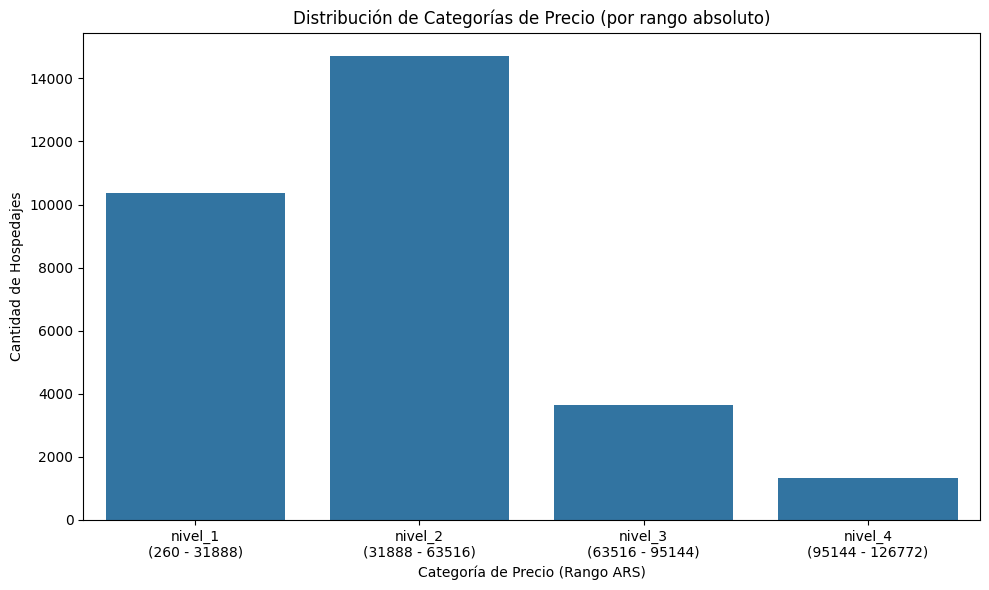

In [532]:
# Definir los cortes personalizados basados en valores del precio (rango absoluto)
min_price = df_airbnb['price'].min()
max_price = df_airbnb['price'].max()
rango = max_price - min_price

# Crear cortes cada 25% del rango total
bins = [min_price,
        min_price + 0.25 * rango,
        min_price + 0.50 * rango,
        min_price + 0.75 * rango,
        max_price]

# Etiquetas
labels = ['nivel_1', 'nivel_2', 'nivel_3', 'nivel_4']

# Crear nueva columna de categoría por rango absoluto
df_airbnb['categoria_precio'] = pd.cut(df_airbnb['price'], bins=bins, labels=labels, include_lowest=True)

# Ver la distribución
counts_rango = df_airbnb['categoria_precio'].value_counts().sort_index()

# Graficar
etiquetas_rango = [f"{label}\n({int(bins[i])} - {int(bins[i+1])})" for i, label in enumerate(labels)]

plt.figure(figsize=(10, 6))
sns.barplot(x=etiquetas_rango, y=counts_rango.values)
plt.title('Distribución de Categorías de Precio (por rango absoluto)')
plt.xlabel('Categoría de Precio (Rango ARS)')
plt.ylabel('Cantidad de Hospedajes')
plt.tight_layout()
plt.show()

In [533]:
df_airbnb['categoria_precio'].value_counts()

categoria_precio
nivel_2    14708
nivel_1    10359
nivel_3     3627
nivel_4     1324
Name: count, dtype: int64

La distribución resultante de la variable categoria_precio muestra un desequilibrio entre clases, siendo la mayoría de los hospedajes clasificados en los niveles nivel_1 y nivel_2, y una menor proporción en nivel_3 y especialmente en nivel_4. Este desbalance es esperable, dado que los cortes fueron realizados sobre rangos absolutos del precio y reflejan la concentración real del mercado en hospedajes de precio bajo y medio-bajo, típica de la oferta en la ciudad.

Al momento de entrenar los modelos, será necesario tener en cuenta este desbalance. Para ello, se podrán aplicar estrategias como ponderación de clases o técnicas de reesampling (por ejemplo, sobremuestreo de clases minoritarias o submuestreo de clases mayoritarias), con el objetivo de mejorar la capacidad del modelo para predecir correctamente las clases menos representadas, evitando un sesgo hacia las clases mayoritarias.

## B) Transformación de Features
El objetivo consiste en realizar la transformación de los datos con diversas técnicas para adaptar los datos a la aplicación de modelos de machine learning, se aplicaron técnicas de conversión y de escalamiento

In [534]:
#Imputación de nulos en campos binarios, donde el nulo corresponde al valor '0'
df_airbnb['host_is_superhost'] = df_airbnb['host_is_superhost'].fillna('0')
df_airbnb['host_identity_verified'] = df_airbnb['host_identity_verified'].fillna('0')

df_airbnb.loc[(df_airbnb['has_review'] == 0) & (df_airbnb['reviews_per_month'].isna()), 'reviews_per_month'] = 0

In [535]:
# Datos para train
y= df_airbnb['categoria_precio'].copy()
X= df_airbnb.drop(['categoria_precio','price'], axis=1)

#Split de datos de entrenamiento y testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [536]:
X_train = X_train.astype(object).where(pd.notna(X_train), np.nan)
X_test = X_test.astype(object).where(pd.notna(X_test), np.nan)

#Separamos las columnas segun el tipo de transformaciones a aplicar
numerica_media = ['host_response_rate','host_acceptance_rate',
                  'review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',
                  'review_scores_communication','review_scores_location','review_scores_value','rating','antiguedad_host_anios']

numerica_moda = ['host_listings_count','host_total_listings_count','bathrooms','bedrooms','beds']

nominales_ordinal = ['host_response_time']

nominales = ['neighbourhood_cleansed','property_type']

nomimal_one_hot = ['room_type']


# Todas las columnas que estás usando en los transformadores
columnas_transformadas = (
    numerica_media +
    numerica_moda +
    nominales_ordinal +
    nominales +
    nomimal_one_hot
)

# Asegurarte de que no haya duplicados
columnas_transformadas = list(set(columnas_transformadas))

# Obtener las columnas restantes (passthrough).
columnas_passthrough = [col for col in X_train.columns if col not in columnas_transformadas]

#Variables numéricas sin nulos, aplicamos StandardScaler estandarizar variables ante grandes diferencias de escala
dummy_passthrough = Pipeline([
            ('scaler', StandardScaler())
        ])

#Variables ordinales: Imputación de nulos por la moda, ordinal encoder para transformación en variables numéricas y StandardScaler para escalamiento.
transformar_ordinales = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ('scaler', StandardScaler())
])

#Variables ordinales de baja cardinalidad: Imputación de nulos por la moda y one hot encoder para transformación en variables numéricas que representan pocas categorías.
transformar_bajacard = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

#Variables nominales: Imputación de nulos por la moda, target encoder para transformación de variables que no representan ordinalidad y StandardScaler para escalamiento.
transformar_nominales = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('target_encoder', TargetEncoder(handle_unknown='value')),
    ('scaler', StandardScaler()),
])

#Variables numéricas: Imputación de nulos por la media y StandardScaler para escalamiento.
transformar_numericas_media = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

#Variables numéricas: Imputación de nulos por la moda (ya que poseen números enteros y es mas representativo la frecuencia de valores) y StandardScaler para escalamiento.
transformar_numericas_moda = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler())
])

In [537]:
# Creamos el pipeline de preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('num_media', transformar_numericas_media, numerica_media),
        ('num_moda', transformar_numericas_moda, numerica_moda),
        ('nominales_ordinal', transformar_ordinales, nominales_ordinal),
        ('nominales', transformar_nominales, nominales),
        ('nomimal_one_hot', transformar_bajacard, nomimal_one_hot),
        ('dummy_passthrough', dummy_passthrough, columnas_passthrough),

    ],
    remainder='passthrough' # Esto es best-practice para evitar columnas no transformadas
)

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
pipeline.fit(X_train,y_train)

,steps,"[('preprocessor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_media', ...), ('num_moda', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [538]:
X_train_procesado = pipeline.transform(X_train)
X_test_procesado = pipeline.transform(X_test)

In [539]:
preprocessor_ajustado = pipeline.named_steps['preprocessor']

# OneHotEncoder: obtener nombres generados
onehot_step = preprocessor_ajustado.named_transformers_['nomimal_one_hot'].named_steps['onehot']
onehot_nombres = onehot_step.get_feature_names_out(nomimal_one_hot).tolist()

# TargetEncoder: una columna por variable original
target_nombres = nominales  # mantiene los nombres originales

# Columnas ordinales: una por cada variable
ordinales_nombres = nominales_ordinal

# Columnas numéricas (media y moda)
numericas_nombres = numerica_media + numerica_moda

# Columnas passthrough (sin transformar)
passthrough_nombres = columnas_passthrough

# Armado final en orden definido en ColumnTransformer
columnas_df = (
    numerica_media +                # num_media
    numerica_moda +                # num_moda
    ordinales_nombres +            # ordinales
    target_nombres +               # target encoder
    onehot_nombres +               # one-hot
    passthrough_nombres            # dummy_passthrough
)

# Crear los DataFrames finales con columnas y mismo índice
X_train_preproc = pd.DataFrame(X_train_procesado, columns=columnas_df, index=X_train.index)
X_test_preproc = pd.DataFrame(X_test_procesado, columns=columnas_df, index=X_test.index)



In [540]:
X_train_preproc

,host_response_rate,host_acceptance_rate,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,rating,antiguedad_host_anios,host_listings_count,host_total_listings_count,bathrooms,bedrooms,beds,host_response_time,neighbourhood_cleansed,property_type,room_type_Hotel room,room_type_Private room,room_type_Shared room,host_is_superhost,host_identity_verified,latitude,longitude,accommodates,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,has_review
28246,0.147758,0.418627,-0.134371,0.558389,-0.017257,0.439654,0.433054,0.497103,0.695307,0.514904,0.759590,1.327982,0.893269,-0.355828,-0.138267,0.160568,0.497852,-0.824249,0.111935,0.0,0.0,0.0,1.187059,0.076302,-0.718740,0.967945,0.932960,-0.176788,-1.017144,-0.167365,-0.190356,-1.303322,-1.346053,-0.186062,-1.331083,0.021407,1.213543,1.127782,1.035120,-0.395299,-0.553418,-0.442908,0.152731,-0.308859,-0.510106,-0.551607,-0.707195,0.905590,0.923250,-0.196527,-0.067213,0.600884,0.397736
23935,0.309252,0.538681,0.624116,0.241366,0.699507,0.439654,0.433054,0.497103,0.401400,0.547266,0.018108,-0.410368,-0.354048,-0.355828,-0.138267,-0.646437,0.497852,-1.134980,-3.372270,0.0,1.0,0.0,1.187059,0.076302,-0.980885,-0.649336,-1.465852,-0.116664,-0.114366,-0.235115,-0.129679,-0.550009,-0.589637,-0.121789,-0.571742,0.021407,-0.416588,-1.173726,-0.849837,-0.096817,-0.425194,-0.024599,-0.562077,0.017127,-0.029279,-0.084008,-0.707195,-0.374442,-0.445105,0.958115,-0.067213,-0.028970,0.397736
22185,-0.659716,0.498663,0.624116,0.558389,0.126096,-0.273129,-0.241543,-0.336615,0.695307,0.158913,-0.549205,0.079308,-0.045571,-0.355828,-0.138267,0.160568,-0.797567,-0.353509,0.111935,0.0,0.0,0.0,-0.842418,0.076302,-2.037620,1.499995,0.932960,-0.116664,-0.114366,-0.099616,-0.129679,-0.550009,-0.589637,-0.121789,-0.571742,0.021407,0.784561,0.892934,0.866820,0.342129,-0.532047,-0.373190,-0.562077,0.496519,-0.372727,-0.473674,1.414037,-0.083525,-0.066624,-0.196527,-0.067213,-0.531355,0.397736
11827,0.309252,0.458645,0.229703,0.241366,0.212108,0.261458,0.264404,0.246987,0.225056,0.210694,-0.044766,-0.459336,-0.367460,-0.355828,-0.138267,-0.646437,-2.092987,0.478769,0.111935,0.0,0.0,0.0,-0.842418,0.076302,0.214871,0.431717,-0.666248,-0.176788,1.933728,-0.167365,-0.190356,1.159000,1.126412,-0.186062,1.150943,0.021407,-1.360347,-1.690392,-1.994275,-0.649888,-0.638900,-0.721781,-0.562077,-0.864953,-0.716174,-0.863340,1.414037,-0.432625,-0.415991,-0.196527,-0.067213,-0.898770,-2.514228
22334,-5.073904,-3.463116,0.229703,0.241366,0.212108,0.261458,0.264404,0.246987,0.225056,0.210694,-1.172888,-0.459336,-0.380872,-0.355828,-0.138267,-0.646437,-3.388406,-1.134980,0.111935,0.0,0.0,0.0,-0.842418,0.076302,-1.036287,-0.492640,-0.666248,-0.116664,-0.855452,-0.099616,-0.129679,-1.168400,-1.210576,-0.121789,-1.195081,0.021407,1.127746,1.080812,1.001460,0.386023,-0.638900,-0.721781,-0.562077,0.544458,-0.716174,-0.863340,-0.707195,-0.432625,-0.415991,-0.196527,-0.067213,-0.898770,-2.514228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29802,0.309252,0.458645,0.229703,0.241366,0.212108,0.261458,0.264404,0.246987,0.225056,0.210694,-1.829815,-0.459336,-0.380872,3.631041,5.174290,10.651628,0.497852,-0.253315,-3.646665,0.0,1.0,0.0,-0.842418,0.0763

In [541]:
X_test_preproc

,host_response_rate,host_acceptance_rate,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,rating,antiguedad_host_anios,host_listings_count,host_total_listings_count,bathrooms,bedrooms,beds,host_response_time,neighbourhood_cleansed,property_type,room_type_Hotel room,room_type_Private room,room_type_Shared room,host_is_superhost,host_identity_verified,latitude,longitude,accommodates,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,has_review
25333,0.309252,-0.781912,-0.892857,0.558389,0.699507,-1.342304,-1.253439,-5.755785,0.695307,-0.941421,-1.313090,-0.434852,-0.367460,-0.355828,-0.138267,-0.646437,0.497852,-1.337113,-3.372270,0.0,1.0,0.0,-0.842418,0.076302,-1.936755,1.150976,-1.465852,-0.236912,-0.114366,-0.235115,-0.251033,-0.550009,-0.589637,-0.250335,-0.571742,0.021407,1.213543,1.127782,1.035120,1.228798,-0.596159,-0.582344,-0.562077,1.186843,-0.578795,-0.707474,-0.707195,-0.403533,-0.445105,0.573234,-0.067213,-0.163939,0.397736
26458,0.309252,0.538681,0.229703,0.241366,0.212108,0.261458,0.264404,0.246987,0.225056,0.210694,-0.106195,-0.459336,-0.380872,-0.355828,-1.466406,0.160568,0.497852,0.749364,0.111935,0.0,0.0,0.0,-0.842418,0.076302,0.342508,0.165301,0.932960,0.544695,-0.114366,0.645629,0.537765,-0.550009,-0.589637,0.585214,-0.571742,0.021407,-1.360347,-1.690392,-1.994275,0.157772,-0.638900,-0.721781,-0.562077,0.017127,-0.716174,-0.863340,-0.707195,-0.432625,-0.415991,-0.196527,-0.067213,-0.898770,-2.514228
24872,0.309252,0.458645,0.229703,0.241366,0.212108,0.261458,0.264404,0.246987,0.225056,0.210694,-1.627461,-0.459336,-0.380872,-0.355828,-0.138267,-0.646437,0.497852,-1.201646,0.111935,0.0,0.0,0.0,-0.842418,0.076302,0.315660,-1.986392,-0.666248,5.114091,-0.855452,5.794591,5.149199,-1.168400,-1.210576,5.469966,-1.195081,0.021407,1.213543,1.127782,1.035120,-1.167843,-0.638900,-0.721781,-0.562077,-1.152588,-0.716174,-0.863340,-0.707195,-0.432625,-0.415991,-0.196527,-0.067213,-0.898770,-2.514228
23421,0.309252,0.538681,0.442079,0.209664,0.384131,0.047623,0.230675,0.497103,0.518963,0.385452,1.553105,1.034176,1.590694,0.640889,1.189872,1.774577,0.497852,-0.824249,0.111935,0.0,0.0,0.0,1.187059,0.076302,-0.513185,1.540546,3.331772,-0.176788,-0.114366,-0.167365,-0.069002,1.159000,1.126412,-0.186062,1.150943,0.021407,0.612968,0.798995,0.799500,1.167346,-0.254229,0.533146,0.152731,1.119728,0.451548,0.539458,1.414037,1.341964,1.359959,-0.196527,-0.067213,1.050780,0.397736
4605,0.309252,0.458645,0.351060,0.399878,0.441472,0.154541,0.264404,-1.045276,0.401400,0.197748,0.375118,-0.459336,-0.380872,-0.355828,-0.138267,-0.646437,0.497852,-1.530469,0.111935,0.0,0.0,0.0,-0.842418,0.076302,-0.952217,0.195393,-0.666248,-0.056541,-1.022534,-0.031866,-0.069002,-1.307819,-1.350569,-0.057516,-1.335616,0.021407,-1.360347,-1.690392,-1.994275,-1.729693,1.198971,-0.721781,-0.562077,-2.034669,-0.716174,-0.863340,-0.707195,-0.432625,-0.415991,-0.196527,-0.067213,0.023517,0.397736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17092,-0.605884,0.418627,0.624116,-2.611842,-2.167549,0.439654,0.433054,0.497103,0.695307,-0.617793,0.589757,0.985209,0.973741,-0.355828,-0.138267,-0.646437,0.497852,0.478769,0.111935,0.0,0.0,0.0,-0.842418,0.076302,-0.093948,0.531

In [542]:
X_train_preproc.shape

(24014, 53)

#### Verificamos si luego de hacer el procesamiento queda algún nulo en los datos

In [543]:
print(f"Cantidad de nulos en en los datos de entrenamiento: {X_test_preproc.isnull().sum().sum()}")
print(f"Cantidad de nulos en en los datos de testeo: {X_train_preproc.isnull().sum().sum()}")

Cantidad de nulos en en los datos de entrenamiento: 0
Cantidad de nulos en en los datos de testeo: 0


## C) Selección de Features
Aplicamos el test de Información mutua para analizar, tanto en variables categóricas como numéricas, en qué medida nuestras variables proporcionan información sobre nuestra variable objetivo.

### Informacion mutua

In [544]:
#Elegimos 15 variables más informativas
selector_mi = SelectKBest(score_func=mutual_info_classif, k=15)
selector_mi.fit(X_train_preproc, y_train)

# Aplicar el filtro a train
X_train_selected = selector_mi.transform(X_train_preproc)
# Aplicar el filtro a test
X_test_selected = selector_mi.transform(X_test_preproc)

selected_indices = selector_mi.get_support()
selected_features = X_train_preproc.columns[selected_indices]
scores = selector_mi.scores_[selected_indices]
print("\nCaracterísticas seleccionadas (Inf. mutua):")
for feature, score in zip(selected_features, scores):
    print(f"{feature}: {score:.4f}")

print(f"\nShape del dataset de train después de la selección): {X_train_selected.shape}")
print(f"Shape del dataset de test después de la selección): {X_test_selected.shape}")


Características seleccionadas (Inf. mutua):
antiguedad_host_anios: 0.1288
host_listings_count: 0.0434
host_total_listings_count: 0.0452
bathrooms: 0.0702
bedrooms: 0.0719
beds: 0.0537
neighbourhood_cleansed: 0.0448
property_type: 0.0458
room_type_Private room: 0.0302
latitude: 0.0540
longitude: 0.0546
accommodates: 0.1046
calculated_host_listings_count: 0.0453
calculated_host_listings_count_entire_homes: 0.0656
calculated_host_listings_count_private_rooms: 0.0377

Shape del dataset de train después de la selección): (24014, 15)
Shape del dataset de test después de la selección): (6004, 15)


A partir del análisis de información mutua, se identificaron las características con mayor poder explicativo respecto a la variable categoria_precio. Entre las variables más relevantes se destacan aquellas relacionadas con la ubicación del hospedaje, como latitude, longitude y neighbourhood_cleansed, lo cual resulta esperable dado que la zona geográfica suele ser un factor determinante en el precio.
También aparecen como importantes variables asociadas a la capacidad y el tamaño del alojamiento, como accommodates, beds, bedrooms y bathrooms, además de property_type, que hace referencia al tipo de inmueble (departamento, casa, etc.).
Un resultado interesante es la alta relevancia de la variable antiguedad_host_anios

#### Graficamos los score de las variables

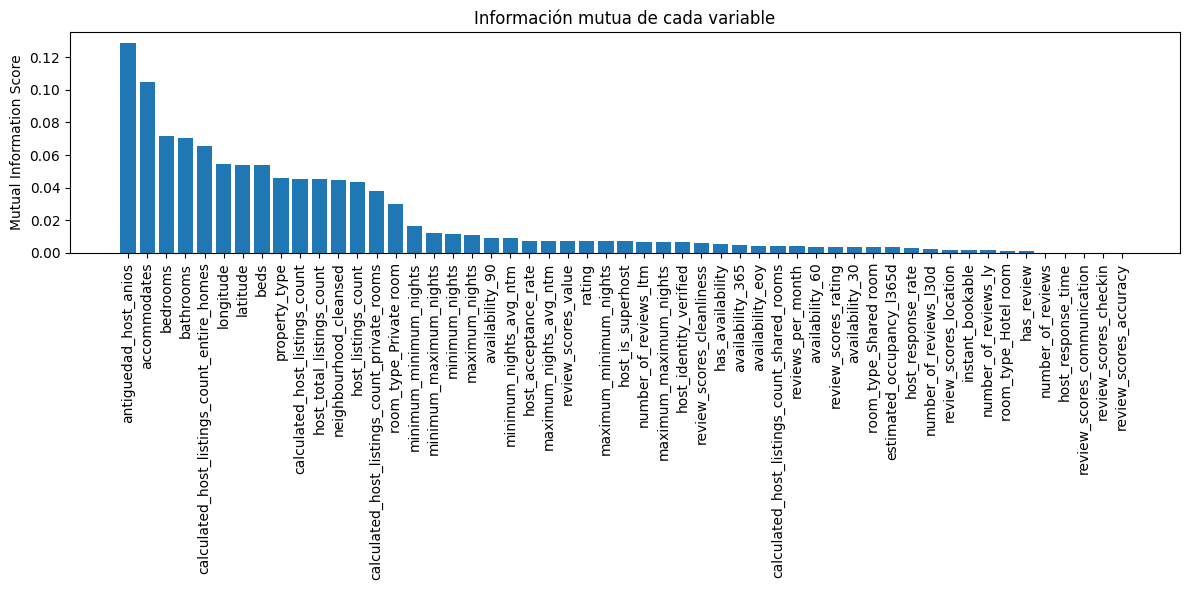

In [545]:
import matplotlib.pyplot as plt

# Ordenar todas las features por score
all_scores = selector_mi.scores_
all_features = X_train_preproc.columns

# Ordenar
sorted_indices = all_scores.argsort()[::-1]
sorted_scores = all_scores[sorted_indices]
sorted_features = all_features[sorted_indices]

# Graficar
plt.figure(figsize=(12, 6))
plt.bar(range(len(sorted_scores)), sorted_scores, tick_label=sorted_features)
plt.xticks(rotation=90)
plt.title("Información mutua de cada variable")
plt.ylabel("Mutual Information Score")
plt.tight_layout()
plt.show()

Resultados:

Se seleccionaron las 15 variables con mayor puntaje de información mutua.

Las variables elegidas son aquellas que comparten mayor información con la clase objetivo, es decir, que ayudan mejor a diferenciar entre las categorías de precio.

Este enfoque permite reducir la dimensionalidad del dataset y eliminar variables redundantes o irrelevantes, lo que mejora la capacidad generalizadora del modelo.

### D) Extracción de Features
Aplicamos para esta sección dos técnicas: Análisis de Componentes Principales (PCA) y Análisis Discriminante Lineal (LDA)

#### PCA

In [546]:
# Aplicar PCA
pca = PCA(n_components=4)
components = pca.fit_transform(X_train_selected) # Hacer PCA sobre el dataset filtrado por inf. mutua

# Resultado como DataFrame para graficar o analizar
df_components = pd.DataFrame(components, columns=['PC1', 'PC2','PC3', 'PC4'])
df_components['categoria_precio'] = y_train


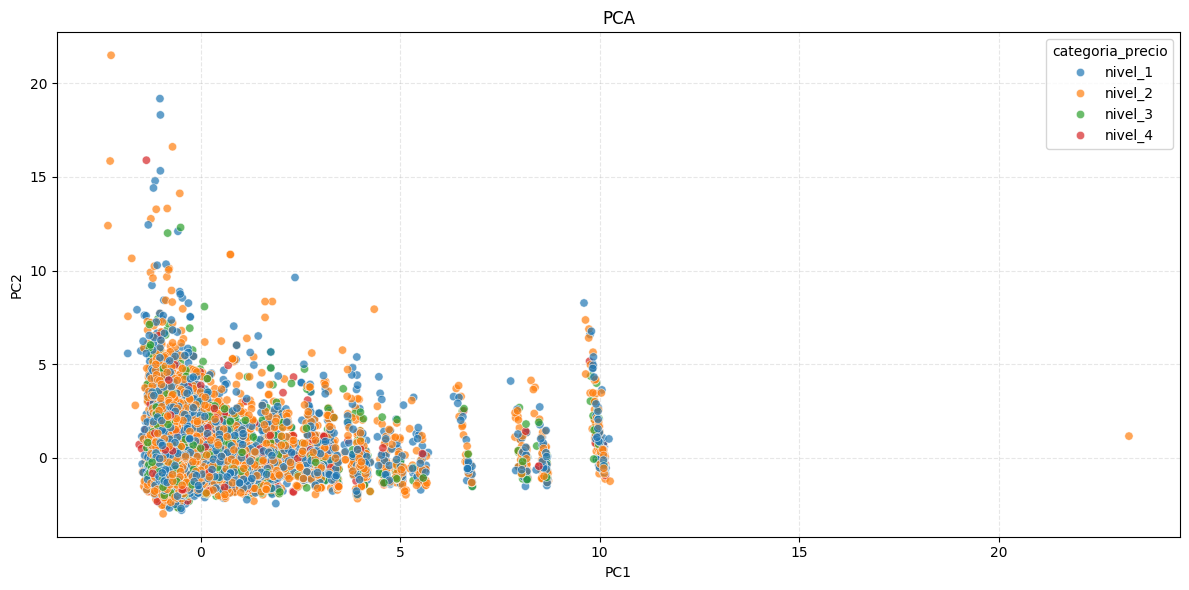

In [547]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=df_components, x='PC1', y='PC2', hue='categoria_precio', alpha=0.7)
plt.title('PCA')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [548]:
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

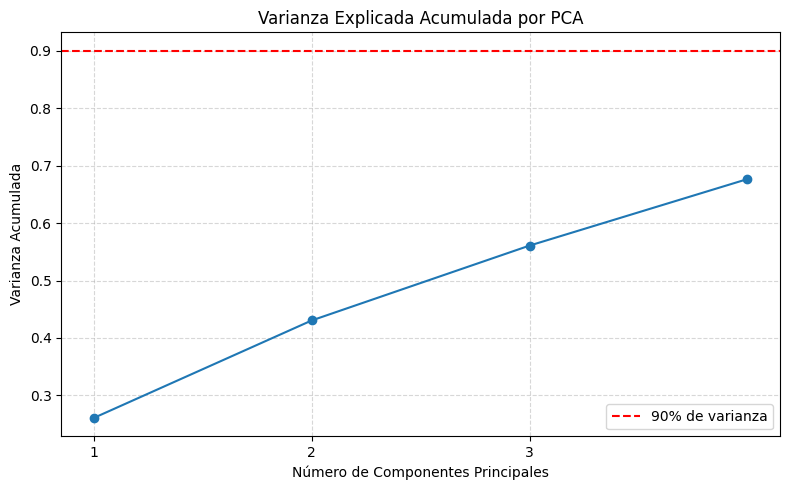

In [549]:
# Gráfico
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, marker='o', linestyle='-')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Acumulada')
plt.title('Varianza Explicada Acumulada por PCA')
plt.axhline(y=0.9, color='red', linestyle='--', label='90% de varianza')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks([1, 2, 3])
plt.legend()
plt.tight_layout()
plt.show()

Al aplicar PCA (Análisis de Componentes Principales) sobre las variables seleccionadas, no se observó una separación clara entre las distintas categorías de precio en el espacio definido por los primeros componentes. Si bien los primeros componentes (como PC1 y PC2) explican una parte relevante de la varianza del conjunto de datos, no parece haber una única dirección dominante que permita discriminar claramente las clases.

#### LDA

In [550]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder
import pandas as pd

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

lda = LinearDiscriminantAnalysis(n_components=3)
X_lda = lda.fit_transform(X_train_selected, y_train_encoded)


df_lda = pd.DataFrame(X_lda, columns=['LD1', 'LD2', 'LD3'])
df_lda['categoria_precio'] = y_train.reset_index(drop=True)

In [551]:
df_lda

,LD1,LD2,LD3,categoria_precio
0,0.079853,-0.583506,0.398952,nivel_2
1,-2.798224,2.027302,-1.232066,nivel_1
2,0.088965,-0.032704,0.773053,nivel_2
3,-0.280639,-0.354744,0.073725,nivel_3
4,-1.284328,-0.141362,0.562355,nivel_1
...,...,...,...,...
24009,6.674947,4.772897,-2.779516,nivel_1
24010,-0.205983,-0.224593,-0.078655,nivel_2
24011,-0.490420,-0.298082,0.358252,nivel_2
24012,-0.243178,-0.119058,0.130133,nivel_2


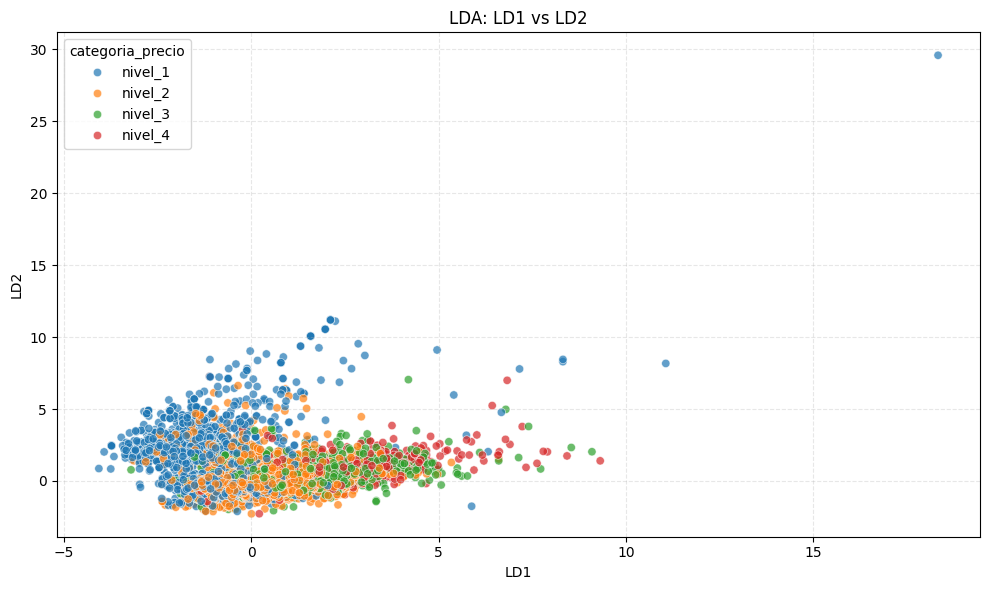

In [552]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_lda, x='LD1', y='LD2', hue='categoria_precio', alpha=0.7)
plt.title('LDA: LD1 vs LD2')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

En los resultados obtenidos, puede observarse que algunas categorías se agrupan de manera más compacta o tienden a separarse respecto de otras en el espacio generado por los discriminantes lineales. Esto indica que existe cierta estructura en los datos que LDA logra capturar, y que puede ser aprovechada para mejorar el rendimiento de los modelos de clasificación

Observamos cuales son las columnas mas relevantes para LD1

In [553]:
selected_features = X_train_preproc.columns[selector_mi.get_support()]

loadings = pd.DataFrame(
    lda.scalings_,
    index=selected_features,
    columns=[f"LD{i+1}" for i in range(lda.scalings_.shape[1])]
)

loadings['LD1'].abs().sort_values(ascending=False)

calculated_host_listings_count_entire_homes     1.336903
calculated_host_listings_count                  1.102658
accommodates                                    0.600210
room_type_Private room                          0.593159
neighbourhood_cleansed                          0.515405
property_type                                   0.431618
host_listings_count                             0.304365
bedrooms                                        0.273337
host_total_listings_count                       0.266667
bathrooms                                       0.263460
latitude                                        0.082981
calculated_host_listings_count_private_rooms    0.040875
longitude                                       0.033557
antiguedad_host_anios                           0.029728
beds                                            0.000919
Name: LD1, dtype: float64

#### Conclusiones de los Resultados
- Aunque PCA es útil para simplificar el espacio de datos sin depender de la variable objetivo, LDA mostró un mejor desempeño en términos de separación entre clases, lo que la hace más adecuada para problemas de clasificación supervisada como el abordado en este trabajo. 
- LDA no solo mejora la interpretación del espacio reducido, sino que también puede beneficiar el rendimiento de modelos clasificadores posteriores.